## AutoEncoders and t-Distributed Stochastic Neighbor Embedding (tSNE)

Clustering is an unsupervised technique that can be applied in many different application domains to group data in such a way that similar data instances belong to the same cluster and dissimilar data instances are grouped into different clusters.

However, clustering algorithms have problems to cluster high-dimensional datasets (like images) due to the curse of dimensionality. Auto-Encoders can reduce the dimensionality of the data to improve the accuracy of the subsequent clustering.

The idea of Auto-Encoders therefore is to reduce the dimensionality by retaining the most essential information of the data.

We will use, as a toy example, the well-known MNIST dataset, which consists of 28x28 pixel grayscale images of handwritten digits (0-9). Since the focus here is unsupervised analysis, we will pretend the digit labels are not available.


### Loading the necessary libraries.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
# from torch.optim.lr_scheduler import StepLR

### Define the autoencoder architecture

AutoEncoders work by compressing the input into a latent-space representation and then reconstructing the output from this representation.

An AutoEncoder consists of two main parts: the encoder and the decoder. The encoder compresses the input and the decoder attempts to recreate the input from the compressed version. During this process, the network learns to retain only the most important aspects of the data.

In [2]:
# Define the CNN autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### Download and prepare the MNIST dataset.

PyTorch provides a convenient way to do this using the torchvision datasets module.

In [3]:
# Define transforms to normalize the data.

# Convert a PIL Image to a tensor of shape (C x H x W) in the range [0.0, 1.0]
# and normalize the image in the range [-1,1]: image = (image - mean) / std
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Convert a PIL Image to a tensor of shape (C x H x W) in the range [0.0, 1.0]
transform = transforms.ToTensor()

# Download and load the MNIST training data.
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Download and load the MNIST test data.
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Define the data loaders

# Shuffling is done during the training to make sure we aren’t exposing our model
# to the same cycle (order) of data in every epoch. It is basically done to ensure
# the model isn’t adapting its learning to any kind of spurious pattern
train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True)

# We don’t need to shuffle the test dataset, since no training is done, the model
# is used in model.eval() and thus the order of samples won’t change the results.
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Initialize the model, loss function and optimizer

#### Loss function
The loss function is used to measure model performance by calculating the deviation of a model’s predictions from the correct, “ground truth” predictions. Training a neural network is the process of looking for model weights that minimize the value of loss function.

#### Optimizer
The optimizer updates the weights based on the gradients that have been calculated. The learning rate hyperparameter determines the size of the steps the optimization algorithm takes when adjusting the weights of the model in response to the gradients.

There are lots of different optimization algorithms which lead to different optimizers, e.g. SGD (Stochastic Gradient Descent) and Adam (Adaptive Moment Estimation).


In [4]:
# torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Train AutoEncoder on the image dataset.

This training involves learning to compress the image data into a lower-dimensional latent space while preserving its key features.

In [5]:
# Training loop
epochs = 10
training_losses = []
val_losses = []
log_interval = 100

for epoch in range(epochs):
    val_loss = 0

    # Training phase
    model.train()
    for batch_idx,(data, _) in enumerate(train_loader):
        data = data.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        # collect statistics every log_interval mini-batches
        if batch_idx % log_interval == 0:
            iteration = epoch * len(train_loader) + batch_idx
            training_losses.append((iteration, loss.item()))

    # Validation phase
    model.eval()
    with torch.no_grad():
        for i,(data, _) in enumerate(test_loader):
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data)
            val_loss += loss.item() * data.size(0)

    val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

# print(training_losses)

Epoch 1/10, Validation Loss: 0.0514
Epoch 2/10, Validation Loss: 0.0250
Epoch 3/10, Validation Loss: 0.0160
Epoch 4/10, Validation Loss: 0.0115
Epoch 5/10, Validation Loss: 0.0088
Epoch 6/10, Validation Loss: 0.0071
Epoch 7/10, Validation Loss: 0.0062
Epoch 8/10, Validation Loss: 0.0057
Epoch 9/10, Validation Loss: 0.0053
Epoch 10/10, Validation Loss: 0.0051


### Plot the training and validation losses

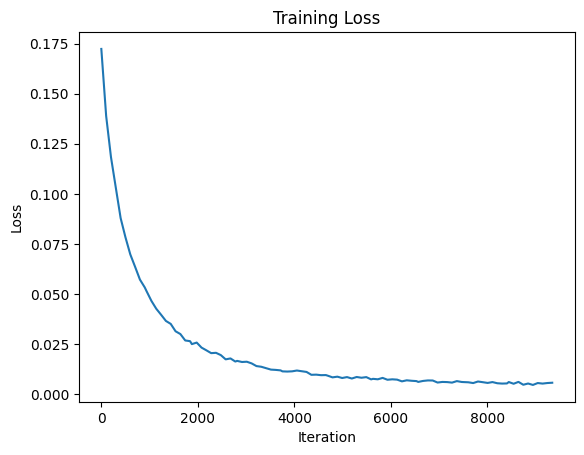

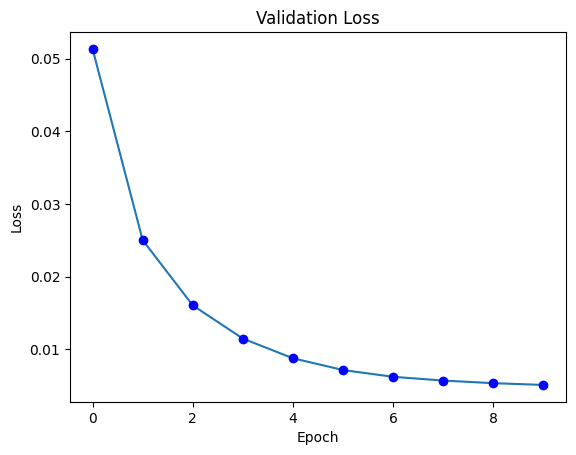

In [6]:
# Plot the training losses
x_val, y_val = map(list, zip(*training_losses))
plt.plot(x_val, y_val)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot the validation losses
plt.plot(val_losses)
plt.plot(val_losses, 'bo')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()

### Extract features using the trained autoencoder

We use the trained encoder part to transform the images into a lower-dimensional latent space and apply t-SNE to these latent space representations.

In [7]:
# Extract features using the trained autoencoder
with torch.no_grad():
    features = []
    for i,(data, _) in enumerate(test_loader):
        data = data.to(device)
        encoded = model.encoder(data)
        features.append(encoded.view(encoded.size(0), -1).cpu().numpy())
features = np.concatenate(features, axis=0)

In [8]:
print(features.shape)

(10000, 196)


In [9]:
# Apply TSNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
tsne_features = tsne.fit_transform(features)

<ipython-input-10-817b5131747b>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_features[:, 0], tsne_features[:, 1], cmap='viridis')


Text(0, 0.5, 't-SNE 2')

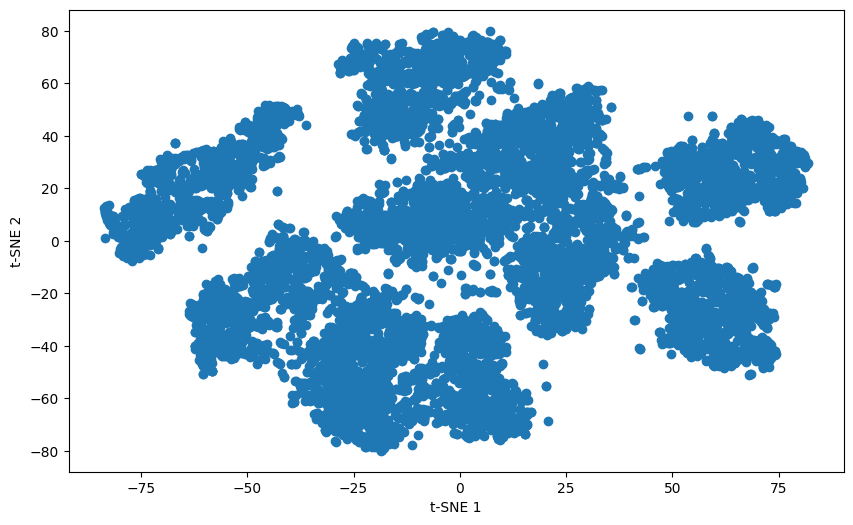

In [10]:
# Plot the TSNE results without label
plt.figure(figsize=(10, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], cmap='viridis')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

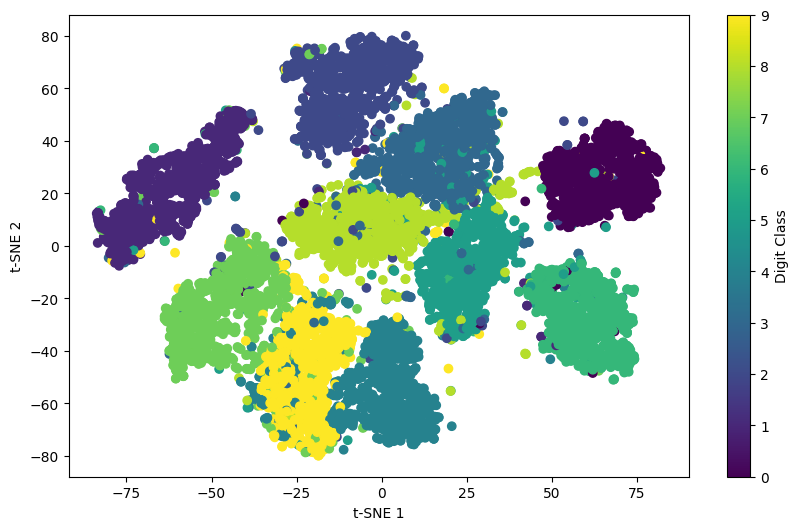

In [11]:
# Plot the TSNE results with label
plt.figure(figsize=(10, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_dataset.targets, cmap='viridis')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Digit Class')
plt.show()

In [ ]:
%%shell
jupyter nbconvert --to html /content/AutoEncoders_tSNE.ipynb

[NbConvertApp] Converting notebook /content/AutoEncoders_tSNE.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 604108 bytes to /content/AutoEncoders_tSNE.html
